## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import sklearn.model_selection as skl
from random import sample
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
95237,00024950_000.png,Infiltration,0,24950,56,F,PA,2474,2429,0.143,0.143,NaN,/data/images_011/images/00024950_000.png
42537,00010949_001.png,No Finding,1,10949,44,F,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00010949_001.png
90375,00022471_000.png,No Finding,0,22471,62,M,PA,2992,2991,0.143,0.143,NaN,/data/images_010/images/00022471_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class'] = -1.0

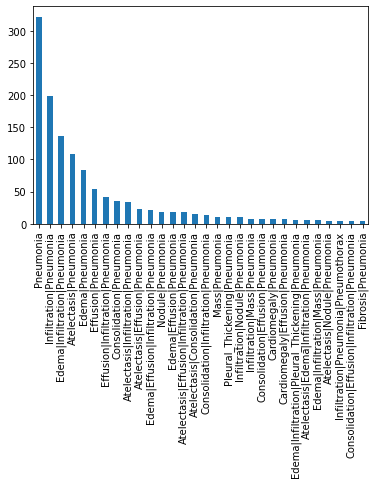

In [5]:
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

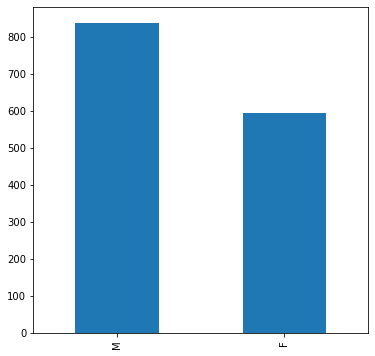

In [6]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia ==1]['Patient Gender'].value_counts().plot(kind='bar')

(array([ 41.,  85., 174., 203., 196., 243., 266., 175.,  39.,   8.]),
 array([ 2. , 10.8, 19.6, 28.4, 37.2, 46. , 54.8, 63.6, 72.4, 81.2, 90. ]),
 <a list of 10 Patch objects>)

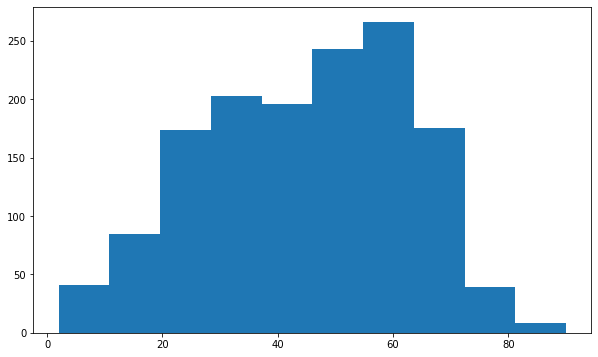

In [7]:
all_xray_df = all_xray_df[all_xray_df['Patient Age'] < 130]

plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'])

## Create your training and testing data:

In [8]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data = skl.train_test_split(df, 
                                   test_size = 0.2, 
                                   stratify = df['Pneumonia'])
    
    return train_data, val_data

In [9]:
train_data, val_data = create_splits(all_xray_df)

print('Training data - Pneumonia: ', train_data['Pneumonia'].sum()/len(train_data))
print('Training data total records:', len(train_data))
print('Validation data - Pneumonia: ', val_data['Pneumonia'].sum()/len(val_data))
print('Validation data total records:', len(val_data))

Training data - Pneumonia:  0.012756040721206917
Training data total records: 89683
Validation data - Pneumonia:  0.01275589848802462
Validation data total records: 22421


Good division between sets. Now we need to balance the training data set to be able to detect pnemonia better by raising the amount of pneumonia in the training set.

In [10]:
p_inds = train_data[train_data.Pneumonia==1].index.tolist()
np_inds = train_data[train_data.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_data = train_data.loc[p_inds + np_sample]

print('Training data - Pneumonia (adjusted): ', train_data['Pneumonia'].sum()/len(train_data))
print('Training data total records:', len(train_data))

Training data - Pneumonia (adjusted):  0.5
Training data total records: 2288


In [11]:
p_inds = val_data[val_data.Pneumonia==1].index.tolist()
np_inds = val_data[val_data.Pneumonia==0].index.tolist()

# The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
np_sample = sample(np_inds,4*len(p_inds))
val_data = val_data.loc[p_inds + np_sample]

print('Validation data - Pneumonia (adjusted): ', val_data['Pneumonia'].sum()/len(val_data))
print('Validation data total records:', len(val_data))

Validation data - Pneumonia (adjusted):  0.2
Validation data total records: 1430


## Confirm training and validation data sets align to EDA expected distributions

### Patient Gender

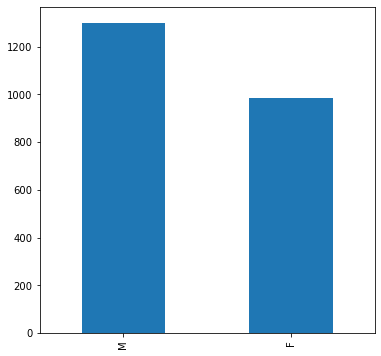

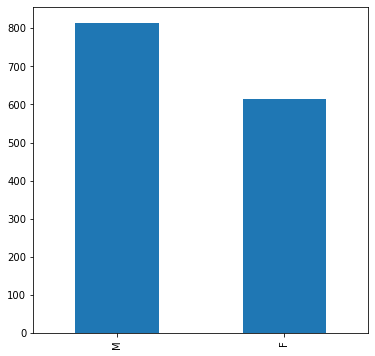

In [12]:
#First Explore Gender
plt.figure(figsize=(6,6))
train_data['Patient Gender'].value_counts().plot(kind='bar')

plt.figure(figsize=(6,6))
val_data['Patient Gender'].value_counts().plot(kind='bar')

Data maintains expected ratios for Patient Gender

## Patient Age

(array([ 21.,  68., 145., 197., 208., 289., 294., 162.,  41.,   5.]),
 array([ 2., 11., 20., 29., 38., 47., 56., 65., 74., 83., 92.]),
 <a list of 10 Patch objects>)

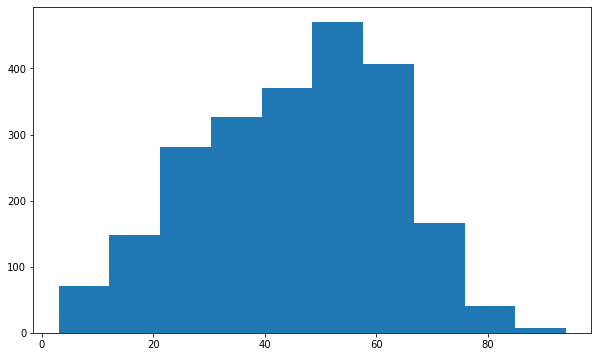

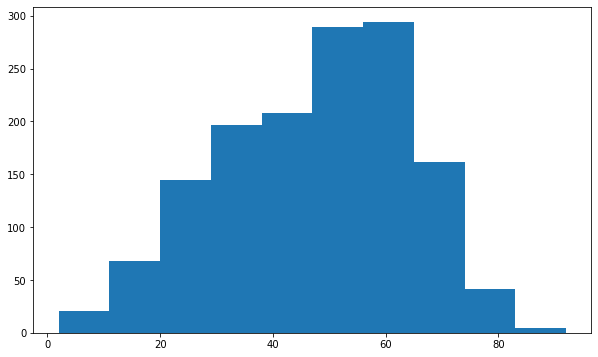

In [13]:
plt.figure(figsize=(10,6))
plt.hist(train_data['Patient Age'])

plt.figure(figsize=(10,6))
plt.hist(val_data['Patient Age'])

There are some small variations in age between data sets and the overall average but everything looks to be good for predicting across 10-80 years old.

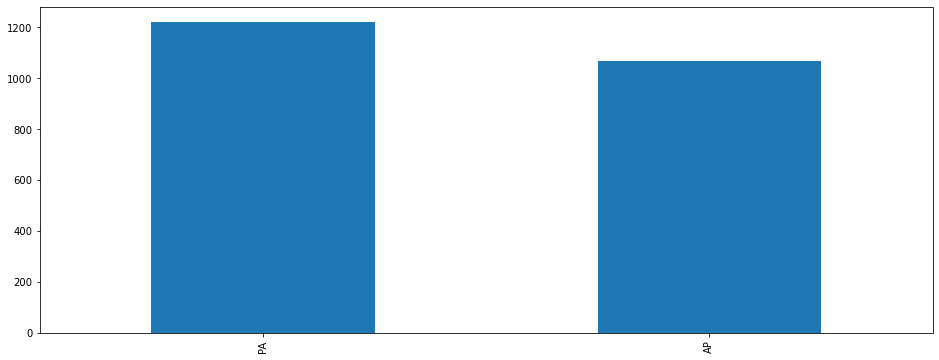

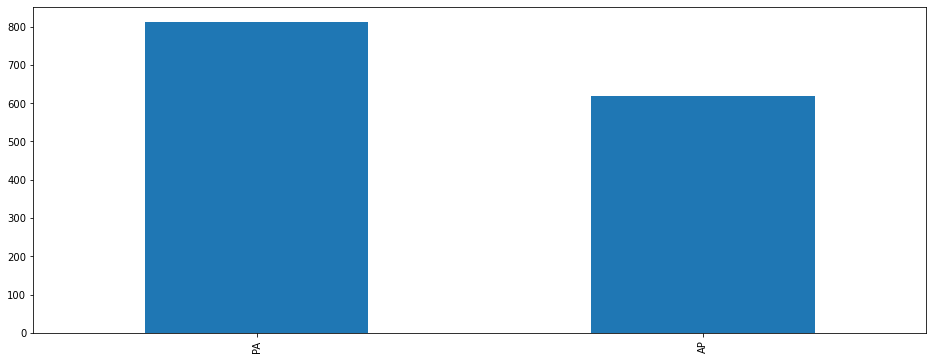

In [14]:
plt.figure(figsize=(16,6))
train_data['View Position'].value_counts()[0:30].plot(kind='bar')

plt.figure(figsize=(16,6))
val_data['View Position'].value_counts()[0:30].plot(kind='bar')

The training data has a higher percentage of PA view position images than the overall dataset. The validation set has a good balance. Presuming the model can be trained, the validation set is stil good to determine if there is an challenge with the ratio of PA/AP view position images.

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [15]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                                  horizontal_flip = True, 
                                  vertical_flip = False, 
                                  height_shift_range= 0.1, 
                                  width_shift_range=0.1, 
                                  rotation_range=20, 
                                  shear_range = 0.1,
                                  zoom_range=0.1)
    
    return my_idg


def make_train_gen(idg, train_data, img_size):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = idg.flow_from_dataframe(dataframe=train_data, 
                                     directory=None, 
                                     x_col = 'path',
                                     y_col = 'Pneumonia',
                                     class_mode = 'binary',
                                     target_size = img_size, 
                                     batch_size = 100
                                     )
    return train_gen


def make_val_gen(idg, val_data, img_size):

    val_gen = idg.flow_from_dataframe(dataframe=val_data, 
                                     directory=None, 
                                     x_col = 'path',
                                     y_col = 'Pneumonia',
                                     class_mode = 'binary',
                                     target_size = img_size, 
                                     batch_size = 100
                                     )    
    return val_gen

In [16]:
train_data['Pneumonia'] = ['positive' if x > 0 else 'negative' for x in train_data['Pneumonia']]
val_data['Pneumonia'] = ['positive' if x > 0 else 'negative' for x in val_data['Pneumonia']]

In [17]:
IMG_SIZE = (224, 224)

idg = my_image_augmentation()

train_gen = make_train_gen(idg, train_data, IMG_SIZE)
val_gen = make_val_gen(idg, val_data, IMG_SIZE)


Found 2288 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [18]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

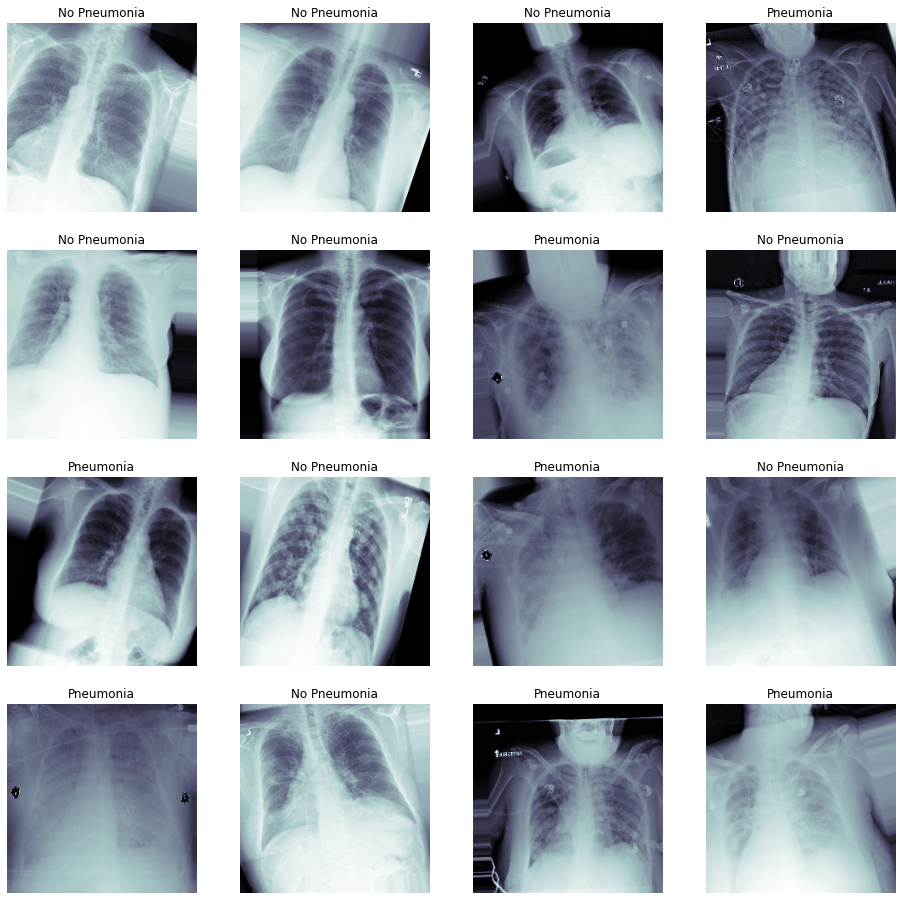

In [19]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [20]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    model = VGG16(include_top=True, weights='imagenet')
    #model.summary()
    
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input,
                      outputs=transfer_layer.output)
    
    
    return vgg_model


In [21]:
def build_my_model(vgg_model):
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    new_model = Sequential()

    new_model.add(vgg_model)
    
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    #new_model.add(Flatten())
    #new_model.add(Dense(1, activation='relu'))

    new_model.add(Flatten())
    new_model.add(Dropout(0.3))
    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.3))
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.3))
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dense(1, activation='sigmoid'))
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    optimizer = Adam(lr=1e-3)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']    

    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)    
    
    return new_model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [33]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

monitor_metric = 'binary_accuracy'
monitor_metric_min_max = 'max'

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= monitor_metric,
                             verbose=1, 
                             save_best_only=True, 
                             mode= monitor_metric_min_max, 
                             save_weights_only = True)

early = EarlyStopping(monitor= monitor_metric, 
                      mode= monitor_metric_min_max, 
                      patience=5)

callbacks_list = [checkpoint, early]

### Start training! 

In [34]:
vgg_model = load_pretrained_model()

In [35]:
## train your model

my_model = build_my_model(vgg_model)

history = my_model.fit_generator(train_gen, 
                                 validation_data = (valX, valY), 
                                 #epochs = 200)
                                 epochs = 30, 
                                 callbacks = callbacks_list)

Epoch 1/30
23/23 [==============================] - 62s 3s/step - loss: 1.2365 - binary_accuracy: 0.5092 - val_loss: 0.6934 - val_binary_accuracy: 0.5000

Epoch 00001: binary_accuracy improved from -inf to 0.50918, saving model to xray_class_my_model.best.hdf5
Epoch 2/30
23/23 [==============================] - 61s 3s/step - loss: 0.6821 - binary_accuracy: 0.5682 - val_loss: 0.6029 - val_binary_accuracy: 0.5900

Epoch 00002: binary_accuracy improved from 0.50918 to 0.56818, saving model to xray_class_my_model.best.hdf5
Epoch 3/30
23/23 [==============================] - 60s 3s/step - loss: 0.6805 - binary_accuracy: 0.5861 - val_loss: 0.7636 - val_binary_accuracy: 0.2100

Epoch 00003: binary_accuracy improved from 0.56818 to 0.58610, saving model to xray_class_my_model.best.hdf5
Epoch 4/30
23/23 [==============================] - 61s 3s/step - loss: 0.6731 - binary_accuracy: 0.5809 - val_loss: 0.7281 - val_binary_accuracy: 0.4100

Epoch 00004: binary_accuracy did not improve from 0.5861

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [36]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 100, verbose = True)


100/100 [==============================] - 1s 11ms/step


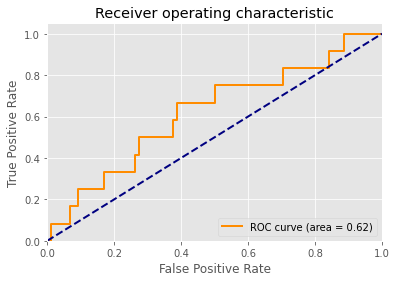

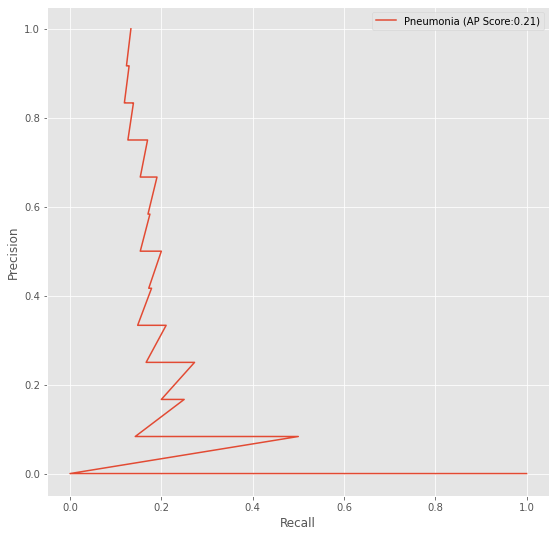

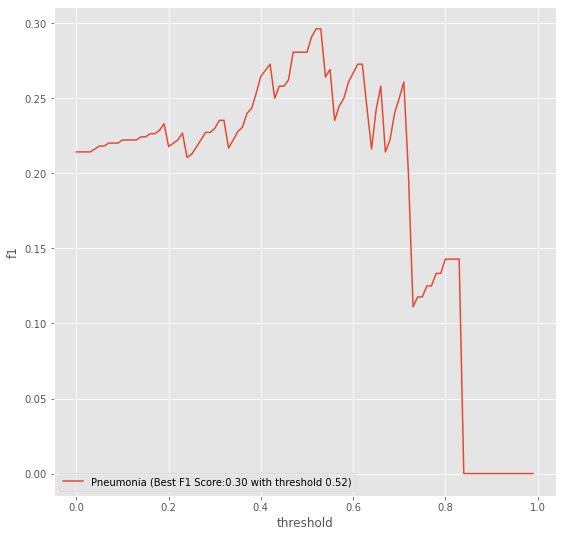

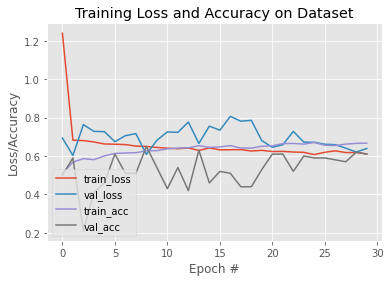

In [37]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    fpr, tpr, _ = roc_curve(t_y, p_y)

    #tpr[np.isnan(tpr)] = 0

    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return


def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    #print("Precision and Recall")
    #print(precision)
    #print(recall)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

    
def plot_f1(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    f1_scores = []
    thresholds = []
    max_f1 = 0
    best_threshold = None
    for t in np.arange(0.0,1,0.01):        
        y_pred_class = p_y > t
        f1 = f1_score(t_y, y_pred_class)
        if max_f1 < f1:
            max_f1 = f1
            best_threshold = t
        f1_scores.append(f1)
        thresholds.append(t)
    
    c_ax.plot(thresholds, f1_scores,
              label = '%s (Best F1 Score:%0.2f with threshold %.2f)'  % ('Pneumonia', max_f1, best_threshold))
    c_ax.legend()
    c_ax.set_xlabel('threshold')
    c_ax.set_ylabel('f1')    
    
    
#Also consider plotting the history of your model training:
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")


## what other performance statistics do you want to include here besides AUC? 
plot_auc(valY, pred_Y)

plot_pr(valY, pred_Y)

plot_f1(valY, pred_Y)

plot_history(history)

In [38]:
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
print(thresholds)

[0.19010998 0.20474246 0.21318983 0.22285746 0.22709978 0.23484418
 0.23631448 0.24907793 0.25095087 0.258058   0.26128623 0.2656089
 0.27378273 0.27412158 0.2981597  0.30646807 0.30864635 0.3200436
 0.3254598  0.33317763 0.33906633 0.34032962 0.34900928 0.35957807
 0.36340272 0.36579382 0.36988753 0.37444174 0.38296995 0.38313937
 0.38561645 0.39452773 0.39670563 0.39690393 0.40370396 0.4112242
 0.42591384 0.42623785 0.43068936 0.43121633 0.45390424 0.46076027
 0.46087202 0.4663768  0.46730468 0.5081016  0.50868154 0.51546675
 0.5374038  0.54529554 0.55458367 0.56076354 0.5674293  0.57570356
 0.5828092  0.5856273  0.59932786 0.60485536 0.62215567 0.6274365
 0.6294012  0.6300714  0.6310236  0.6341699  0.63550866 0.6404317
 0.6423364  0.643572   0.6466588  0.6509163  0.6519196  0.66252625
 0.66616297 0.6662294  0.6715672  0.68161    0.6816725  0.6997945
 0.70735455 0.71248263 0.7142733  0.7168409  0.7202744  0.72193223
 0.73255455 0.75427884 0.77440625 0.79247224 0.8383997  0.8441321 ]


In [59]:
# Look at the threshold where precision is 0.8
precision_value = 0.75
idx = (np.abs(precision - precision_value)).argmin()
print(idx)
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

88
Precision is: 0.5
Recall is: 0.08333333333333333
Threshold is: 0.8383997
F1 Score is: 0.14285714285714285


In [40]:
# Look at the threshold where recall is 0.8
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.11904761904761904
Recall is: 0.8333333333333334
Threshold is: 0.23631448
F1 Score is: 0.20833333333333331


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that opt

In [50]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

#threshold = 0.5125144
threshold = 0.52

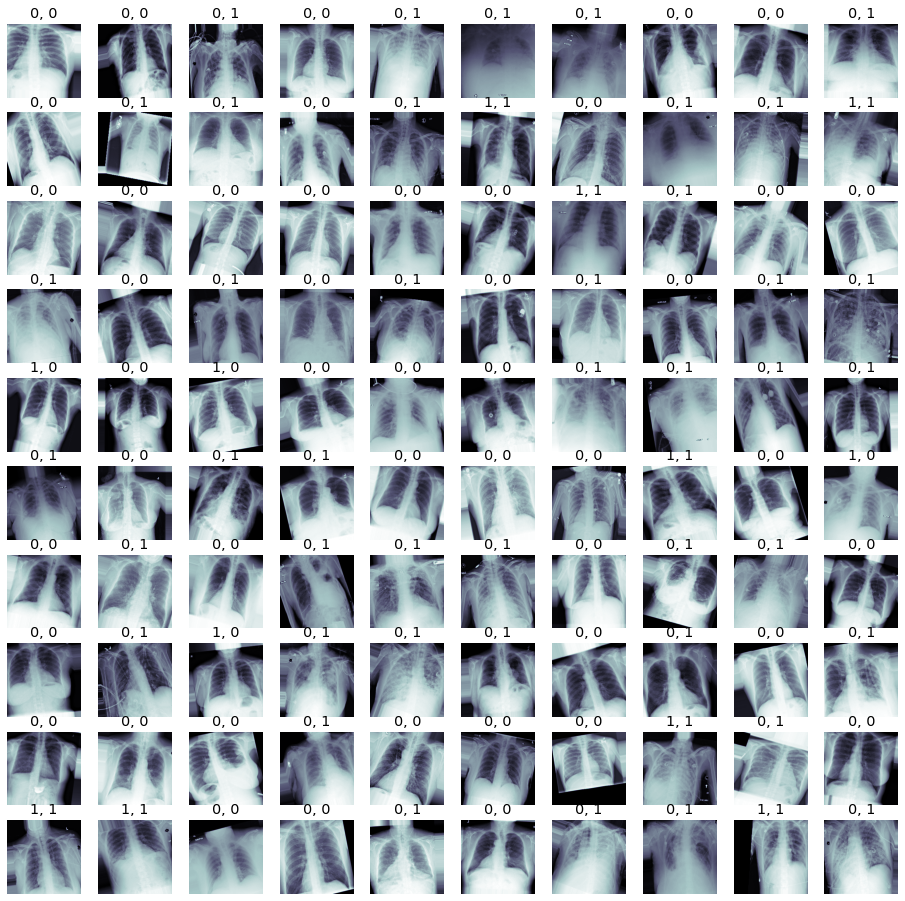

In [48]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1
    
#pred_Y

In [49]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)